In [1]:
import numpy as np
import pandas as pd
import pickle

from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from unidecode import unidecode

# from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import metrics
from simpletransformers.model import TransformerModel
import tensorflow_hub as hub

from imblearn.over_sampling import SMOTE

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import SpatialDropout1D, Input, Embedding, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, MaxPool1D, Dense, Flatten, Bidirectional, LSTM, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, GRU
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import shap
import lime

from lime.lime_text import LimeTextExplainer

%matplotlib inline
# from nltk.stem.snowball import SnowballStemmer

# stemmer = SnowballStemmer("portuguese")

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../../data/mpst-movie-plot-synopses-with-tags/mpst_full_data.csv')

In [3]:
df.shape

(14828, 6)

In [4]:
df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [5]:
#Criando um coluna para cada rótulo (onehot encoder)

df_tags_onehot = (df.tags.str.split('\s*,\s*', expand=True)
   .stack()
   .str.get_dummies()
   .sum(level=0))

In [6]:
df_tags_onehot['plot_synopsis'] = df['plot_synopsis']
df_tags_onehot['split'] = df['split']

In [34]:
tags, plot_synopsis, split = [], [], []

for i, row in tqdm_notebook(df.iterrows()):
    
    tags_aux = row['tags'].split(',')
    
    for tag in tags_aux:
        
        tags.append(tag.strip())
        plot_synopsis.append(row['plot_synopsis'])
        split.append(row['split'])

In [35]:
print(Counter(tags).most_common())

[('murder', 5782), ('violence', 4426), ('flashback', 2937), ('romantic', 2906), ('cult', 2647), ('revenge', 2468), ('psychedelic', 1897), ('comedy', 1859), ('suspenseful', 1086), ('good versus evil', 875), ('humor', 822), ('satire', 816), ('entertaining', 749), ('neo noir', 745), ('action', 664), ('sadist', 652), ('insanity', 636), ('tragedy', 597), ('fantasy', 564), ('paranormal', 546), ('boring', 525), ('mystery', 519), ('horror', 486), ('melodrama', 457), ('cruelty', 442), ('gothic', 441), ('dramatic', 412), ('dark', 405), ('atmospheric', 396), ('storytelling', 364), ('sci-fi', 309), ('psychological', 289), ('historical', 272), ('absurd', 270), ('prank', 255), ('sentimental', 233), ('philosophical', 228), ('avant garde', 220), ('bleak', 211), ('depressing', 205), ('plot twist', 205), ('alternate reality', 205), ('realism', 204), ('cute', 197), ('stupid', 190), ('intrigue', 168), ('pornographic', 163), ('home movie', 153), ('haunting', 151), ('historical fiction', 143), ('allegory', 

Podemos ver o desbalanceamento entre as classes no Counter acima

In [13]:
tags = [tupla[0] for tupla in Counter(tags).most_common()]

In [14]:
len(tags)

71

71 classes distintas são muitas classes, o que já indica a complexidade do problema

Text(0.5, 0, '# of categories')

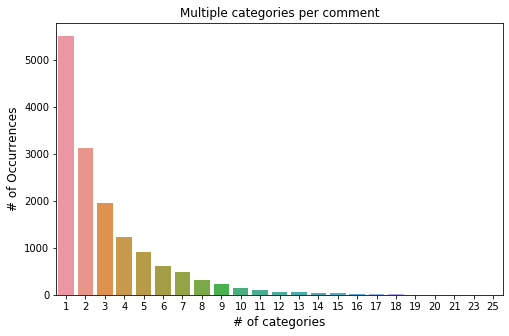

In [32]:
rowsums = df_tags_onehot.iloc[:,:-2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

A maioria das sinopses possuem apenas 1 classe, mas vemos que existem várias amostras com mais de um rótulo, chegando até 25 rótulos (não sei como pode um filme ter tantos gêneros associados a ele hahaha)

# Pré-processamento

In [16]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    
    text = unidecode(text)
    text = BeautifulSoup(text, "html.parser").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [17]:
print('Limpando sinopse...')
df_tags_onehot['plot_synopsis'] = df_tags_onehot['plot_synopsis'].apply(clean_text)

Limpando sinopse...


In [14]:
print(len(df_tags_onehot[df_tags_onehot['split'] == 'train']))
print(len(df_tags_onehot[df_tags_onehot['split'] == 'test']))
print(len(df_tags_onehot[df_tags_onehot['split'] == 'val']))

9489
2966
2373


In [15]:
df_tags_onehot.head()

,absurd,action,adult comedy,allegory,alternate history,alternate reality,anti war,atmospheric,autobiographical,avant garde,...,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical,plot_synopsis,split
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,note synopsis orginal italian release segments...,train
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,two thousand years ago nhagruul foul sorcerer ...,train
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,matuscheks gift store budapest workplace alfre...,test
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,glenn holland morning person anyones standards...,train
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,may 1980 cuban man named tony montana al pacin...,val


# Penalizando o desbalanceamento aplicando pesos as classes na Regressão Logística

In [36]:
weights = np.linspace(0.05, 0.95, 20)
for tag in tags:
    
    print('Trainning model for --->', tag)
    
    df_aux = df_tags_onehot.copy()
    
    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
      
                ('clf', LogisticRegression()),
            ])
    
    gsc = GridSearchCV(
    estimator=pipeline,
    param_grid={
        'clf__class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
    )
    
    
    x_train = df_aux[df_aux['split'] == 'train']['plot_synopsis']
    
    x_test = df_aux[df_aux['split'] == 'test']['plot_synopsis']
    
    y_train = df_aux[df_aux['split'] == 'train'][tag]
    
    y_test = df_aux[df_aux['split'] == 'test'][tag]
    
    grid_result = gsc.fit(x_train, y_train)
    
    params = grid_result.best_params_['clf__class_weight']
    
    pipeline_final = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(class_weight = params)),
            ])
    
    #trainning
    pipeline_final.fit(x_train, y_train)
    
    #evaluate
    preds = pipeline_final.predict(x_test)
    
    print(classification_report(y_test, preds))
    
    #save_model
    pickle.dump(pipeline_final, open('../../data/models/'+tag+'.pkl', 'wb'))
    
    print('-----------------\n')

Trainning model for ---> murder
              precision    recall  f1-score   support

           0       0.85      0.61      0.71      1811
           1       0.58      0.83      0.68      1155

    accuracy                           0.70      2966
   macro avg       0.72      0.72      0.70      2966
weighted avg       0.75      0.70      0.70      2966

-----------------

Trainning model for ---> violence
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      2055
           1       0.52      0.72      0.61       911

    accuracy                           0.71      2966
   macro avg       0.69      0.71      0.69      2966
weighted avg       0.75      0.71      0.72      2966

-----------------

Trainning model for ---> flashback
              precision    recall  f1-score   support

           0       0.90      0.26      0.40      2370
           1       0.23      0.89      0.37       596

    accuracy                           0.38

-----------------

Trainning model for ---> horror
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2874
           1       0.29      0.20      0.23        92

    accuracy                           0.96      2966
   macro avg       0.63      0.59      0.61      2966
weighted avg       0.95      0.96      0.96      2966

-----------------

Trainning model for ---> melodrama
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2873
           1       0.12      0.01      0.02        93

    accuracy                           0.97      2966
   macro avg       0.55      0.50      0.50      2966
weighted avg       0.94      0.97      0.95      2966

-----------------

Trainning model for ---> cruelty
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2869
           1       0.00      0.00      0.00        97

    accuracy             

-----------------

Trainning model for ---> stupid
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2927
           1       0.00      0.00      0.00        39

    accuracy                           0.99      2966
   macro avg       0.49      0.50      0.50      2966
weighted avg       0.97      0.99      0.98      2966

-----------------

Trainning model for ---> intrigue
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2926
           1       0.00      0.00      0.00        40

    accuracy                           0.99      2966
   macro avg       0.49      0.50      0.50      2966
weighted avg       0.97      0.99      0.98      2966

-----------------

Trainning model for ---> pornographic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2938
           1       0.00      0.00      0.00        28

    accuracy         

-----------------

Trainning model for ---> suicidal
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2958
           1       0.00      0.00      0.00         8

    accuracy                           1.00      2966
   macro avg       0.50      0.50      0.50      2966
weighted avg       0.99      1.00      1.00      2966

-----------------

Trainning model for ---> magical realism
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2961
           1       0.00      0.00      0.00         5

    accuracy                           1.00      2966
   macro avg       0.50      0.50      0.50      2966
weighted avg       1.00      1.00      1.00      2966

-----------------

Trainning model for ---> autobiographical
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2958
           1       0.00      0.00      0.00         8

    accu

# Up-sampling na classe minoritária + XGBoost Classifier

In [33]:
from sklearn.utils import resample

In [35]:
for tag in tags:
    
    print('Trainning model for --->', tag)
    
    df_aux = df_tags_onehot.copy()
    
    df_majority = df_aux[df_aux[tag] == 0]
    df_minority = df_aux[df_aux[tag] == 1]
    
    df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123)
    
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    pipeline = Pipeline([('tfidf', TfidfVectorizer()),
      
                ('clf', XGBClassifier(n_estimators=300)),
            ])
    
    x_train = df_upsampled[df_upsampled['split'] == 'train']['plot_synopsis']
    
    x_test = df_upsampled[df_upsampled['split'] == 'test']['plot_synopsis']
    
    y_train = df_upsampled[df_upsampled['split'] == 'train'][tag]
    
    y_test = df_upsampled[df_upsampled['split'] == 'test'][tag]
    
    #trainning
    pipeline.fit(x_train, y_train)
    
    #evaluate
    preds = pipeline.predict(x_test)
    
    print(classification_report(y_test, preds))
    
    #save_model
    pickle.dump(pipeline, open('../../data/models2/'+tag+'.pkl', 'wb'))
    
    print('-----------------\n')

Trainning model for ---> murder
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      1811
           1       0.76      0.58      0.66      1810

    accuracy                           0.70      3621
   macro avg       0.71      0.70      0.70      3621
weighted avg       0.71      0.70      0.70      3621

-----------------

Trainning model for ---> violence
              precision    recall  f1-score   support

           0       0.63      0.86      0.72      2055
           1       0.78      0.50      0.61      2115

    accuracy                           0.68      4170
   macro avg       0.70      0.68      0.67      4170
weighted avg       0.70      0.68      0.67      4170

-----------------

Trainning model for ---> flashback
              precision    recall  f1-score   support

           0       0.51      0.93      0.66      2370
           1       0.74      0.18      0.29      2538

    accuracy                           0.54

-----------------

Trainning model for ---> horror
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      2874
           1       0.95      0.09      0.16      2751

    accuracy                           0.55      5625
   macro avg       0.74      0.54      0.43      5625
weighted avg       0.74      0.55      0.43      5625

-----------------

Trainning model for ---> melodrama
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2873
           1       0.96      0.02      0.04      2911

    accuracy                           0.51      5784
   macro avg       0.73      0.51      0.36      5784
weighted avg       0.73      0.51      0.35      5784

-----------------

Trainning model for ---> cruelty
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2869
           1       0.00      0.00      0.00      3139

    accuracy             

-----------------

Trainning model for ---> stupid
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2927
           1       0.00      0.00      0.00      3000

    accuracy                           0.49      5927
   macro avg       0.25      0.50      0.33      5927
weighted avg       0.24      0.49      0.33      5927

-----------------

Trainning model for ---> intrigue
              precision    recall  f1-score   support

           0       0.46      1.00      0.63      2926
           1       0.00      0.00      0.00      3501

    accuracy                           0.45      6427
   macro avg       0.23      0.50      0.31      6427
weighted avg       0.21      0.45      0.28      6427

-----------------

Trainning model for ---> pornographic
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2938
           1       0.00      0.00      0.00      2541

    accuracy         

-----------------

Trainning model for ---> suicidal
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2958
           1       0.00      0.00      0.00      2192

    accuracy                           0.57      5150
   macro avg       0.29      0.50      0.36      5150
weighted avg       0.33      0.57      0.42      5150

-----------------

Trainning model for ---> magical realism
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      2961
           1       0.00      0.00      0.00      1400

    accuracy                           0.68      4361
   macro avg       0.34      0.50      0.40      4361
weighted avg       0.46      0.68      0.55      4361

-----------------

Trainning model for ---> autobiographical
              precision    recall  f1-score   support

           0       0.52      1.00      0.69      2958
           1       0.00      0.00      0.00      2708

    accu

# Validação

In [18]:
df_validation = df_tags_onehot[df_tags_onehot['split'] == 'val']

In [19]:
df_validation

,absurd,action,adult comedy,allegory,alternate history,alternate reality,anti war,atmospheric,autobiographical,avant garde,...,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical,plot_synopsis,split
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,may 1980 cuban man named tony montana al pacin...,val
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,george falconer colin firth approaches car acc...,val
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,film begins closeup jackie kennedy natalie por...,val
20,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,years eve detroits oldest police station preci...,val
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,civilrights era jackson mississippi 23yearold ...,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,peppermint patty practicing figure skating coa...,val
14795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,set london 1938 film focuses highly successful...,val
14796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,two police detectives lyon single childless in...,val
14812,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,bloodc set isolated rural town shore lake suwa...,val


In [15]:
dict_models = {}

for tag in tags:
    
    dict_models[tag] = pickle.load(open('../../data/models/'+tag+'.pkl', 'rb'))

In [26]:
pickle.dump(dict_models, open('../../data/models/dict_models.pkl', 'wb'))

In [25]:
for i, row in df_validation.iterrows():
    
    print('\n--------- Amostra', str(i), '---------')
    
    for tag in list(df_validation.columns)[:-2]:
        
        pred = dict_models[tag].predict([row['plot_synopsis']])
    
        print('Tag: ', tag, '----- Valor:', str(row[tag]), '/', 'Previsto:', str(pred[0]))
            
    
    


--------- Amostra 4 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 1 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 1 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 1 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 1
Tag:  cu

Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----

Tag:  murder ----- Valor: 0 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 1 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful --

Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 1
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring -----

Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 1 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 91 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 1 / Previsto: 1
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobio

Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 1 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 1
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsi

Tag:  fantasy ----- Valor: 1 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 1 / Previsto: 

Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 1 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto

Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 0
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 1 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ---

Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 1
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0

Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 240 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 1 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 1 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
T

Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 1 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 1
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful --

Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 0
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 1 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  

Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 0
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 270 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto:

Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 1 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 

Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 1 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 1 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 1
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----

Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto:

Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 1 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 1 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 1
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 349 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previ

Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting 

Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 1
Tag:  romantic ----- Valor: 1 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 404 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previ

Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 1
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 1
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytel

Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Va

Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 1 / Previsto: 1
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 0
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 456 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality --

Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto

Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 1
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  f

Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 0
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 1 / Previsto: 0
Tag:  

Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 536 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 1
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto:

Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 1 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 1 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 1 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimenta

Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 1
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1


Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 1 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 1 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 610 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0

Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romanti

Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 1 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 1
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 1 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  got

Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 1
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytel

Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good versus evil ----- Valor: 1 / Previsto: 1
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting 

Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 1 / Previsto: 0
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 1 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 706 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto:

Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 1 / Previsto: 0
Tag:  romantic ----- Valor: 1 / Previsto: 1
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful --

Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 0
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 1 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:

Tag:  revenge ----- Valor: 1 / Previsto: 1
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 1 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 762 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war -

Tag:  historical fiction ----- Valor: 1 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 1 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Ta

Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 817 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto:

Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 1
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 1
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 1 / Previsto: 1
Tag:  thought-p

Tag:  suspenseful ----- Valor: 0 / Previsto: 0
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 1 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 865 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / P

Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 1 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 1 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 1
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 1

Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 1 / Previsto: 1
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 1
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytel

Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 1 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 1 / Previsto: 1
Tag:  good ver

Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  f

Tag:  comedy ----- Valor: 1 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 0
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 0
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring -----

Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 1 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1032 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto

Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 1 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0

Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 1 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
T

Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 0
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 1 / Previsto: 1
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimenta

Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 1 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 1 / Previsto: 0
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 1 / Previsto: 1
Tag:  good ver

Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 1 / Previsto: 0
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 1 / Previsto: 1
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1138 ---------
Tag:  absurd ----- Valor: 0 

Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 0
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 1 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto:

Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 0
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1165 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 1 / Previsto: 0


Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1179 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0


Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 1
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 1 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Ta

Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 1 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0

Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 1
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 0 / Previsto: 1
Tag:  good ver

Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback ----- Valor: 1 / Previsto: 1
Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 1 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 0
Tag:  insanity ----- Valor: 1 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 1 / Previsto: 1
Tag:  mystery ----- Valor: 1 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Prev

Tag:  pornographic ----- Valor: 0 / Previsto: 0
Tag:  prank ----- Valor: 0 / Previsto: 0
Tag:  psychedelic ----- Valor: 0 / Previsto: 1
Tag:  psychological ----- Valor: 0 / Previsto: 0
Tag:  queer ----- Valor: 0 / Previsto: 0
Tag:  realism ----- Valor: 0 / Previsto: 0
Tag:  revenge ----- Valor: 0 / Previsto: 0
Tag:  romantic ----- Valor: 0 / Previsto: 0
Tag:  sadist ----- Valor: 0 / Previsto: 0
Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1276 ---------
Tag:  absurd ----- Valor: 0 

Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 1
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 0
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
T

Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 0
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 0 / Previsto: 0
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1320 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 0
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
T

Tag:  good versus evil ----- Valor: 0 / Previsto: 0
Tag:  gothic ----- Valor: 0 / Previsto: 0
Tag:  grindhouse film ----- Valor: 0 / Previsto: 0
Tag:  haunting ----- Valor: 0 / Previsto: 0
Tag:  historical ----- Valor: 0 / Previsto: 0
Tag:  historical fiction ----- Valor: 0 / Previsto: 0
Tag:  home movie ----- Valor: 0 / Previsto: 0
Tag:  horror ----- Valor: 0 / Previsto: 0
Tag:  humor ----- Valor: 0 / Previsto: 1
Tag:  insanity ----- Valor: 0 / Previsto: 0
Tag:  inspiring ----- Valor: 0 / Previsto: 0
Tag:  intrigue ----- Valor: 0 / Previsto: 0
Tag:  magical realism ----- Valor: 0 / Previsto: 0
Tag:  melodrama ----- Valor: 0 / Previsto: 0
Tag:  murder ----- Valor: 0 / Previsto: 1
Tag:  mystery ----- Valor: 0 / Previsto: 0
Tag:  neo noir ----- Valor: 0 / Previsto: 0
Tag:  non fiction ----- Valor: 0 / Previsto: 0
Tag:  paranormal ----- Valor: 0 / Previsto: 0
Tag:  philosophical ----- Valor: 0 / Previsto: 0
Tag:  plot twist ----- Valor: 0 / Previsto: 0
Tag:  pornographic ----- Valor: 0 / 

Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
Tag:  avant garde ----- Valor: 0 / Previsto: 0
Tag:  blaxploitation ----- Valor: 0 / Previsto: 0
Tag:  bleak ----- Valor: 0 / Previsto: 0
Tag:  boring ----- Valor: 0 / Previsto: 0
Tag:  brainwashing ----- Valor: 0 / Previsto: 0
Tag:  christian film ----- Valor: 0 / Previsto: 0
Tag:  claustrophobic ----- Valor: 0 / Previsto: 0
Tag:  clever ----- Valor: 0 / Previsto: 0
Tag:  comedy ----- Valor: 0 / Previsto: 0
Tag:  comic ----- Valor: 0 / Previsto: 0
Tag:  cruelty ----- Valor: 0 / Previsto: 0
Tag:  cult ----- Valor: 0 / Previsto: 0
Tag:  cute ----- Valor: 0 / Previsto: 0
Tag:  dark ----- Valor: 0 / Previsto: 0
Tag:  depressing ----- Valor: 0 / Previsto: 0
Tag:  dramatic ----- Valor: 0 / Previsto: 0
Tag:  entertaining ----- Valor: 0 / Previsto: 0
Tag:  fantasy ----- Valor: 0 / Previsto: 0
Tag:  feel-good ----- Valor: 0 / Previsto: 0
Tag:  flashback

Tag:  satire ----- Valor: 0 / Previsto: 0
Tag:  sci-fi ----- Valor: 0 / Previsto: 0
Tag:  sentimental ----- Valor: 0 / Previsto: 0
Tag:  storytelling ----- Valor: 0 / Previsto: 0
Tag:  stupid ----- Valor: 0 / Previsto: 0
Tag:  suicidal ----- Valor: 0 / Previsto: 0
Tag:  suspenseful ----- Valor: 0 / Previsto: 1
Tag:  thought-provoking ----- Valor: 0 / Previsto: 0
Tag:  tragedy ----- Valor: 0 / Previsto: 0
Tag:  violence ----- Valor: 1 / Previsto: 1
Tag:  western ----- Valor: 0 / Previsto: 0
Tag:  whimsical ----- Valor: 0 / Previsto: 0

--------- Amostra 1379 ---------
Tag:  absurd ----- Valor: 0 / Previsto: 0
Tag:  action ----- Valor: 0 / Previsto: 1
Tag:  adult comedy ----- Valor: 0 / Previsto: 0
Tag:  allegory ----- Valor: 0 / Previsto: 0
Tag:  alternate history ----- Valor: 0 / Previsto: 0
Tag:  alternate reality ----- Valor: 0 / Previsto: 0
Tag:  anti war ----- Valor: 0 / Previsto: 0
Tag:  atmospheric ----- Valor: 0 / Previsto: 0
Tag:  autobiographical ----- Valor: 0 / Previsto: 0
T

KeyboardInterrupt: 

# Conclusão

O dataset apresentando para o desafio apresenta o pior cenário possível para um problema de classificação, que é uma alta taxa de desbalanceamento e alta quantidade de classes possíveis, ainda por cima se trata de um modelo multi-label.

Uma possível tratativa seria tentar agrupar as classes quanto a sua semântica, vectorizando os textos e aplicando uma treinamento não supervisionado para identificar clusters entre as classes, usando K-means ou um Modelo de Mistura Gaussiana.

